# Cold ions: obtaining robust, configurable multi-qubit gates
**Obtaining control solutions for parallel and specifiable multi-qubit gates using Q-CTRL pulses**

BOULDER OPAL enables you to optimize controls to achieve a target operation on your cold ion hardware. In this Application note, you'll find the steps needed to obtain control solutions for trapped ions. You'll learn how to optimize controls for robustness to frequency detuning and pulse timing errors, and how to verify the controls' robustness.  

First, investigate Q-CTRL solutions for [two qubits](#Creating-Q-CTRL-pulses-for-two-qubit-gates), before learning about [experimental validation](#Experimental-validation-of-two-ion-gates) of our control methodology. Subsequently, you can explore examples that demonstrate our [highly-configurable control solutions](https://onlinelibrary.wiley.com/doi/full/10.1002/qute.202000044): user-specified target operations can include [parallel multi-qubit gates](#Creating-Q-CTRL-pulses-for-parallel-2-of-5-and-3-of-5-qubit-gates), and distinct configurable [relative phases](#Creating-Q-CTRL-pulses-for-six-parallel-2-of-12-qubit-gates) as illustrated for six parallel pairwise gates.

## Imports and initialization

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

plt.style.use(get_qctrl_style())


# Start a session with the API
qctrl = Qctrl()

# Helper function for robustness
def reflect_signal(number_of_segments, phases, moduli):
    """This function reflects a drive signal about its temporal midpoint (Milne et al., Phys. Rev. Applied, 2020).
    The combined signal is returned."""

    phases_diff = phases[1:] - phases[:-1]
    if number_of_segments % 2 == 0:
        moduli_refl = qctrl.operations.reverse(moduli, [0])
        phases_diff_refl = qctrl.operations.concatenate(
            [np.array([0]), qctrl.operations.reverse(phases_diff, [0])],
            0,
        )
        phases_extra = phases[-1] + qctrl.operations.cumulative_sum(phases_diff_refl)
    else:
        moduli_refl = qctrl.operations.reverse(moduli[:-1], [0])
        phases_diff_refl = qctrl.operations.reverse(phases_diff, [0])
        phases_extra = phases[-1] + qctrl.operations.cumulative_sum(phases_diff_refl)

    moduli_comb = qctrl.operations.concatenate([moduli, moduli_refl], 0)
    phases_comb = qctrl.operations.concatenate([phases, phases_extra], 0)
    return moduli_comb, phases_comb


# Helper function for optimization with identical drives in all ions
def optimization_with_identical_drives(
    ion_count,
    number_of_segments,
    duration,
    maximum_rabi_rate,
    lamb_dicke_parameters,
    relative_detunings,
    sample_times,
    robust,
):
    with qctrl.create_graph() as graph:
        # Specification of free variables and combination with reflected signal
        number_of_free_segments = number_of_segments
        if robust == True:
            number_of_free_segments = int(np.ceil(number_of_segments / 2))

        # The drive moduli are free variables here. They can also be restricted or fixed.
        drive_moduli = qctrl.operations.bounded_optimization_variable(
            count=number_of_free_segments,
            lower_bound=0,
            upper_bound=maximum_rabi_rate,
        )
        # The drive phases are free variables here. They can also be restricted or fixed.
        drive_phases = qctrl.operations.unbounded_optimization_variable(
            count=number_of_free_segments,
            initial_lower_bound=0,
            initial_upper_bound=2 * np.pi,
        )

        full_moduli = drive_moduli
        full_phases = drive_phases

        if robust == True:
            full_moduli, full_phases = reflect_signal(
                number_of_segments, drive_phases, drive_moduli
            )

        ion_drive = qctrl.operations.complex_pwc_signal(
            moduli=full_moduli,
            phases=full_phases,
            duration=duration,
            name="ion_drive",
        )

        drives = [ion_drive] * ion_count

        ms_phases = qctrl.operations.ms_phases(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
            sample_times=sample_times,
            name="phases",
        )

        ms_displacements = qctrl.operations.ms_displacements(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
            sample_times=sample_times,
            name="displacements",
        )

        infidelity = qctrl.operations.ms_infidelity(
            phases=ms_phases[-1],
            displacements=ms_displacements[-1],
            target_phases=target,
            name="infidelity",
        )

        if not robust:
            cost = infidelity + 0
        else:
            robust_cost_term = qctrl.operations.ms_dephasing_robust_cost(
                drives=drives,
                lamb_dicke_parameters=lamb_dicke_parameters,
                relative_detunings=relative_detunings,
            )
            cost = infidelity + robust_cost_term

        cost.name = "cost"

    return qctrl.functions.calculate_optimization(
        graph=graph,
        optimization_count=10,
        cost_node_name="cost",
        output_node_names=["displacements", "infidelity", "ion_drive", "phases"],
    )


# Helper function for optimization with different drives for each ion
def optimization_with_different_drives(
    ion_count,
    number_of_segments,
    duration,
    maximum_rabi_rate,
    lamb_dicke_parameters,
    relative_detunings,
    sample_times,
    robust,
    drive_names,
):
    with qctrl.create_graph() as graph:
        # Specification of free variables and combination with reflected signal
        number_of_free_segments = number_of_segments
        if robust == True:
            number_of_free_segments = int(np.ceil(number_of_segments / 2))

        drives = []
        for drive_name in drive_names:
            # The drive moduli are free variables here. They can also be restricted or fixed.
            drive_moduli = qctrl.operations.bounded_optimization_variable(
                count=number_of_free_segments,
                lower_bound=0,
                upper_bound=maximum_rabi_rate,
            )
            # The drive phases are free variables here. They can also be restricted or fixed.
            drive_phases = qctrl.operations.unbounded_optimization_variable(
                count=number_of_free_segments,
                initial_lower_bound=0,
                initial_upper_bound=2 * np.pi,
            )

            full_moduli = drive_moduli
            full_phases = drive_phases

            if robust == True:
                full_moduli, full_phases = reflect_signal(
                    number_of_segments, drive_phases, drive_moduli
                )

            drives.append(
                qctrl.operations.complex_pwc_signal(
                    moduli=drive_moduli,
                    phases=drive_phases,
                    duration=duration,
                    name=drive_name,
                )
            )

        ms_phases = qctrl.operations.ms_phases(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
            sample_times=sample_times,
            name="phases",
        )

        ms_displacements = qctrl.operations.ms_displacements(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
            sample_times=sample_times,
            name="displacements",
        )

        infidelity = qctrl.operations.ms_infidelity(
            phases=ms_phases[-1],
            displacements=ms_displacements[-1],
            target_phases=target,
            name="infidelity",
        )

        if not robust:
            cost = infidelity + 0
        else:
            robust_cost_term = qctrl.operations.ms_dephasing_robust_cost(
                drives=drives,
                lamb_dicke_parameters=lamb_dicke_parameters,
                relative_detunings=relative_detunings,
            )
            cost = infidelity + robust_cost_term

        cost.name = "cost"

    return qctrl.functions.calculate_optimization(
        graph=graph,
        optimization_count=10,
        cost_node_name="cost",
        output_node_names=["displacements", "infidelity", "phases"] + drive_names,
    )

## Creating Q-CTRL pulses for two-qubit gates

For multi-qubit operations, first specify the number and type of ions, as well as other trap and laser characteristics.

In [2]:
# Trap characteristics
number_of_ions = 2

# Laser characteristics
maximum_rabi_rate = 2 * np.pi * 100e3
laser_detuning = 1.6e6 + 4.7e3

# Derived setup parameters
ion_chain_properties = qctrl.functions.calculate_ion_chain_properties(
    atomic_mass=171,  # Yb ions
    ion_count=number_of_ions,
    # Center of mass frequencies
    radial_x_center_of_mass_frequency=1.6e6,
    radial_y_center_of_mass_frequency=1.5e6,
    axial_center_of_mass_frequency=0.3e6,
    # Laser wavevector
    radial_x_wave_number=(2 * np.pi) / 355e-9,
    radial_y_wave_number=(2 * np.pi) / 355e-9,
    axial_wave_number=0,
)

100%|██████████| 100/100 [00:03<00:00, 32.64it/s]


You can then collect the Lamb–Dicke parameters and relative detunings from the result, which will be used in the phase and displacement calculations for ions. For more information, see the [Optimizing Mølmer–Sørensen gates](https://docs.q-ctrl.com/boulder-opal/user-guides/optimizing-molmer-sorensen-gates) user guide.

In [3]:
# Collect Lamb Dicke parameters in the shape
# [<axis>, <collective_mode>, <ion>]
lamb_dicke_parameters = np.asarray(
    [
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.radial_x_mode_properties
        ],
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.radial_y_mode_properties
        ],
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.axial_mode_properties
        ],
    ]
)

# Collect relative detunings in the shape
# [<axis>, <collective_mode>]
relative_detunings = (
    np.asarray(
        [
            [mode.frequency for mode in ion_chain_properties.radial_x_mode_properties],
            [mode.frequency for mode in ion_chain_properties.radial_y_mode_properties],
            [mode.frequency for mode in ion_chain_properties.axial_mode_properties],
        ]
    )
    - laser_detuning
)

M&oslash;lmer-S&oslash;rensen-type operations can be used to entangle multiple ions using pairs of lasers with opposite detunings and a fixed phase relationship. For these operations, the laser detuning should be close to a motional mode frequency, and the displacements in the phase-space of each mode should be small. At the end of the operation, the phase-space trajectories for each mode should return to zero (for no residual state-motional entanglement) and the phase acquired between each pair of ions should correspond to target entangling phases $\psi_{jk}$ between each pair of ions ($j$, $k$), indexing from 0:

$$ U = \exp\left(i \sum_{j=1}^{N-1} \sum_{k=0}^{j-1} \psi_{jk} \sigma_x^j \sigma_x^k \right). $$

Note that multiple entangling operations can be performed in parallel, including multi-qubit entangling operations. In this section you'll explore a two-qubit demonstration, before continuing with more exotic operation demonstrations in later sections. Here, the target two-qubit operation is configured by specifying target relative phases between each ion pair. Element ($j$, $k$) of the target phase array is the relative phase between ions $j$ and $k$, with $k<j$. In the cell below the relative phase for ion pair (1, 0) is set to $\pi/4$ for maximal two-qubit entanglement.

In [4]:
# Operation duration in seconds
duration = 2e-4

# Target phases: element (j,k) is the relative entanglement for ions j and k (k<j)
target = np.array(
    [
        [0, 0],
        [np.pi / 4, 0],
    ]
)

### Generating optimized pulses

Next, specify the control pulses according to the degrees of freedom in the hardware. In this optimization, the complex drive $\gamma (t) = \Omega e^{i \phi}$ jointly addresses both ions in the chain. Alternatively, separate drives can be optimized to individually address each ion; this is demonstrated in later sections. The drives are piecewise-constant with fixed detuning in this example, where the amplitude and phase take constant values for each pulse segment of the given laser drive.

The optimizer attempts to minimize a particular cost. The cost is specified in the below cell
to quantify the distances of the trajectory end-points from the origin, and the differences between the realized and target phases. The infidelity also quantifies the solution performance.

In [5]:
number_of_segments = 64

sample_times = np.linspace(0, duration, number_of_segments)

In [6]:
result_optimal = optimization_with_identical_drives(
    ion_count=number_of_ions,
    number_of_segments=number_of_segments,
    duration=duration,
    maximum_rabi_rate=maximum_rabi_rate,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    sample_times=sample_times,
    robust=False,
)

100%|██████████| 100/100 [00:09<00:00, 11.09it/s]


In [7]:
print("Cost = Infidelity = ", result_optimal.output["infidelity"]["value"])

Cost = Infidelity =  3.4581226771024376e-12


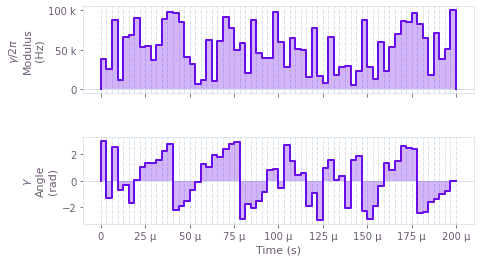

In [8]:
control = {f"$\gamma$": result_optimal.output["ion_drive"]}
plot_controls(plt.figure(), control)

The above figure displays the optimized pulse modulus $\Omega (t)$ and phase $\phi (t)$ that addresses both ions.

It is important to note that the user-specified form of the control pulses can produce control frequencies that bring undesired transitions into resonance. In particular, the lasers are detuned from the carrier transition between the ground and excited states of the ions, however high-frequency components of the control spectrum can induce resonance. To suppress these transitions for piecewise-constant controls, a low-pass filter can be applied to a given solution to eliminate these high-frequency components, typically with very small fidelity loss. Alternatively, the segment durations of piecewise-constant controls can be selected to be multiples of the carrier detuning period. More generally, smooth controls can be optimized such that control frequency components lie below the carrier detuning, for instance using a sinc filter as demonstrated for [six parallel gates](#Creating-Q-CTRL-pulses-for-six-parallel-2-of-12-qubit-gates) below, and in the [Optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/optimization) User guide.

### Generating robust optimized pulses

Robustness to pulse timing errors and mode or laser frequency noise [can be obtained](https://onlinelibrary.wiley.com/doi/full/10.1002/qute.202000044) by imposing additional conditions on the system dynamics. Robustness to these noise sources is given by a combination of symmetry in each ion's drive, as described in ([Milne et al., Phys. Rev. Applied, 2020](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.13.024022)), and optimization such that the centre of mass of each mode's trajectory is at zero. You can do this using the result of  [`qctrl.operations.ms_dephasing_robust_cost`](https://docs.q-ctrl.com/boulder-opal/references/qctrl/Operations/ms_dephasing_robust_cost.html) as an extra term in the cost function. For more information, see the [Optimizing Mølmer–Sørensen gates](https://docs.q-ctrl.com/boulder-opal/user-guides/optimizing-molmer-sorensen-gates) user guide.

In [9]:
# Robust optimization
result_robust = optimization_with_identical_drives(
    ion_count=number_of_ions,
    number_of_segments=number_of_segments,
    duration=duration,
    maximum_rabi_rate=maximum_rabi_rate,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    sample_times=sample_times,
    robust=True,
)

100%|██████████| 100/100 [00:12<00:00,  8.31it/s]


In [10]:
print("Cost = ", result_robust.cost)
print("Infidelity = ", result_robust.output["infidelity"]["value"])

Cost =  1.6618384874284045e-11
Infidelity =  7.500444709762633e-12


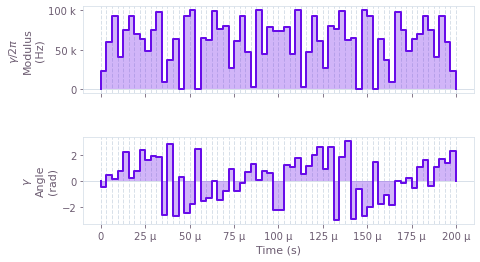

In [11]:
ion = 0
control = {f"$\gamma$": result_robust.output["ion_drive"]}
plot_controls(plt.figure(), control)

The above figure displays the dynamics of the modulus and angle of the robust optimized pulse. The symmetry in time of the modulus values can be observed.

### Operation verification with phase space trajectories

Given the controls, you can visualize the trajectory of the center of a coherent state in (rotating) optical phase space for each mode. The closure of these trajectories is a necessary condition for an effective operation. First examine the (non-robust) standard optimized control, followed by the robust optimized control.

In [12]:
# Sum over ion index to obtain total displacement of the mode.
trajl = np.sum(result_optimal.output["displacements"]["value"], axis=3)

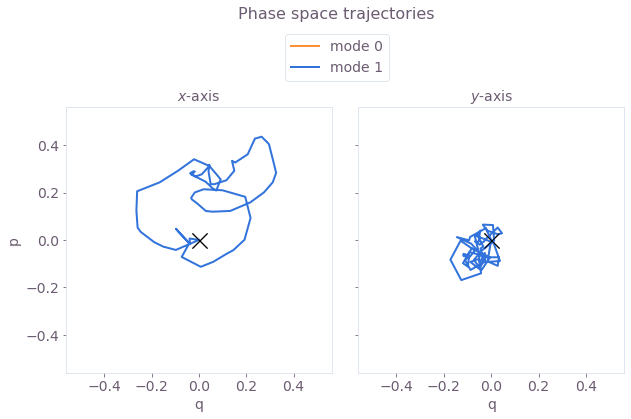

In [13]:
colors = ["#FD8F35", "#3273DC"]
scale = 1.1 * np.max(np.abs(trajl))

gs = gridspec.GridSpec(1, 2, wspace=0.1)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(2.0 * 5)
fig.suptitle("Phase space trajectories", fontsize=16, y=1.15)

ax = fig.add_subplot(gs[0])
ax.tick_params(labelsize=14)
for mode in range(number_of_ions):
    ax.plot(
        np.real(trajl[:, 0, mode]),
        np.imag(trajl[:, 0, mode]),
        label="mode " + str(mode % 2),
        color=colors[mode],
        linewidth=2,
    )
    ax.plot(
        np.real(trajl[-1, 0, mode]),
        np.imag(trajl[-1, 0, mode]),
        marker="x",
        color="black",
        markersize=15,
    )
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_aspect("equal")
ax.set_xlabel("q", fontsize=14)
ax.set_ylabel("p", fontsize=14)
ax.set_title("$x$-axis", fontsize=14)

ax = fig.add_subplot(gs[1])
ax.tick_params(labelsize=14)
for mode in range(number_of_ions):
    ax.plot(
        np.real(trajl[:, 1, mode]),
        np.imag(trajl[:, 1, mode]),
        label="mode " + str(mode % 2),
        color=colors[mode % 2],
        linewidth=2,
    )
    ax.plot(
        np.real(trajl[-1, 1, mode]),
        np.imag(trajl[-1, 1, mode]),
        marker="x",
        color="black",
        markersize=15,
    )
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_aspect("equal")
ax.set_xlabel("q", fontsize=14)
ax.yaxis.set_ticklabels([])
ax.set_title("$y$-axis", fontsize=14)
ax.legend(loc="best", bbox_to_anchor=(0.14, 1.3), fontsize=14)

plt.show()

Here, $q \equiv q_m = (a_m^\dagger + a_m)/\sqrt{2}$ and $p \equiv p_m = i (a_m^\dagger - a_m)/\sqrt{2}$ are the dimensionless quadratures for each mode $m$. The black cross marks the final displacement for each mode. These are overlapping at zero, indicating no residual state-motional entanglement and no motional heating caused by the operations. The z-axis modes are not addressed, and thus have no excursions in phase space.

Next visualize the phase space trajectories for the robust optimized control.

In [14]:
# Sum over ion index to obtain total displacement of the mode.
trajl_r = np.sum(result_robust.output["displacements"]["value"], axis=3)

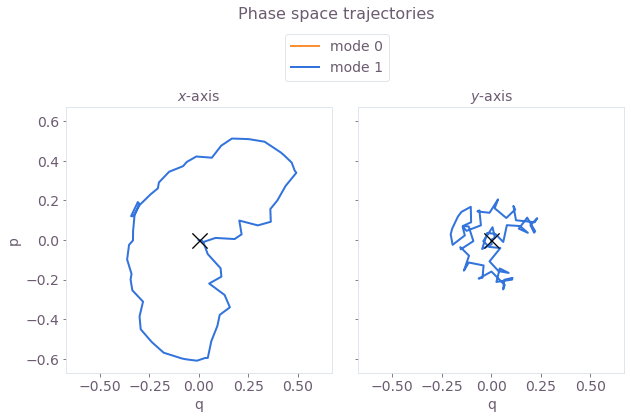

In [15]:
colors = ["#FD8F35", "#3273DC"]
scale = 1.1 * np.max(np.abs(trajl_r))

gs = gridspec.GridSpec(1, 2, wspace=0.1)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(2.0 * 5)
fig.suptitle("Phase space trajectories", fontsize=16, y=1.15)

ax = fig.add_subplot(gs[0])
ax.tick_params(labelsize=14)
for mode in range(number_of_ions):
    ax.plot(
        np.real(trajl_r[:, 0, mode]),
        np.imag(trajl_r[:, 0, mode]),
        label="mode " + str(mode % 2),
        color=colors[mode],
        linewidth=2,
    )
    ax.plot(
        np.real(trajl_r[-1, 0, mode]),
        np.imag(trajl_r[-1, 0, mode]),
        marker="x",
        color="black",
        markersize=15,
    )
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_aspect("equal")
ax.set_xlabel("q", fontsize=14)
ax.set_ylabel("p", fontsize=14)
ax.set_title("$x$-axis", fontsize=14)

ax = fig.add_subplot(gs[1])
ax.tick_params(labelsize=14)
for mode in range(number_of_ions):
    ax.plot(
        np.real(trajl_r[:, 1, mode]),
        np.imag(trajl_r[:, 1, mode]),
        label="mode " + str(mode % 2),
        color=colors[mode % 2],
        linewidth=2,
    )
    ax.plot(
        np.real(trajl_r[-1, 1, mode]),
        np.imag(trajl_r[-1, 1, mode]),
        marker="x",
        color="black",
        markersize=15,
    )
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_aspect("equal")
ax.set_xlabel("q", fontsize=14)
ax.yaxis.set_ticklabels([])
ax.set_title("$y$-axis", fontsize=14)
ax.legend(loc="best", bbox_to_anchor=(0.14, 1.3), fontsize=14)

plt.show()

Here, the center of mass (the value of the integrated trajectory) for each mode is optimized to be close to the origin. Again, the black crosses at the origin indicate no residual state-motional entanglement, which arises from satisfying the center of mass and symmetry conditions.

### Operation verification with relative phase dynamics

You can also obtain the phase accumulation during the gate operation for the pair of ions. The target phase should be achieved at the end of a successful operation. First consider the standard optimized control.

In [16]:
phases = result_optimal.output["phases"]["value"]

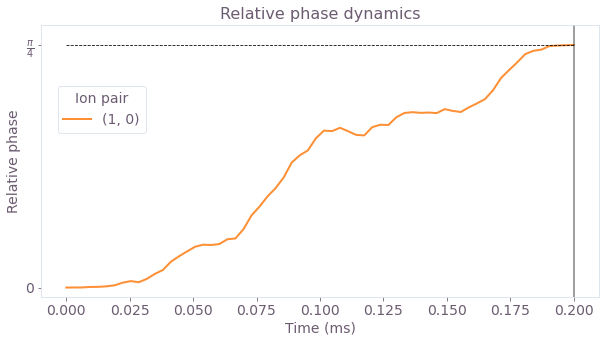

In [17]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.title("Relative phase dynamics", fontsize=16, y=1)
ax.tick_params(labelsize=14)
ion1 = 1
ion2 = 0
x_timing = sample_times * 1e3
ax.plot(
    x_timing,
    phases[:, ion1, ion2],
    color=colors[0],
    label="(" + str(ion1) + ", " + str(ion2) + ")",
    linewidth=2,
)
ax.plot([0, x_timing[-1]], [np.pi / 4, np.pi / 4], "k--", linewidth=0.8)
ax.plot([x_timing[-1], x_timing[-1]], [-1, 1], "k", alpha=0.5)
plt.yticks([0, np.pi / 4], [r"0", r"$\frac{\pi}{4}$"], fontsize=14)
plt.ylim((-0.03, 0.85))
plt.xlabel("Time (ms)", fontsize=14)
plt.ylabel("Relative phase", fontsize=14)
ax.legend(
    ncol=1,
    loc="best",
    bbox_to_anchor=(0.2, 0.8),
    fontsize=14,
    title="Ion pair",
    title_fontsize=14,
)
plt.show()

The figure shows the dynamics of the relative phase between the two ions, over the duration of the gate. Under the optimized control, this evolves from 0 to the target maximally-entangled phase of $\pi/4$ at the end of the operation (marked by the black vertical line). The target phase is marked by the horizontal dashed black line.

Next obtain the phase accumulation for the robust optimized control.

In [18]:
phases_r = result_robust.output["phases"]["value"]

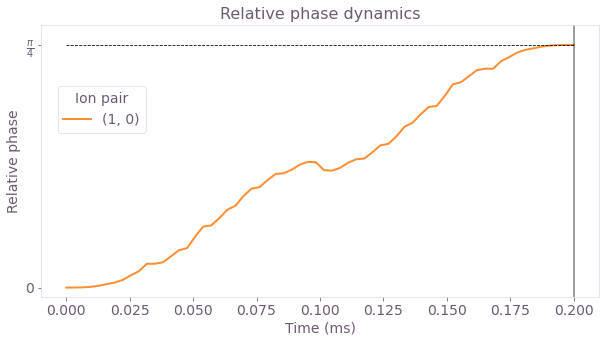

In [19]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.title("Relative phase dynamics", fontsize=16, y=1)
ax.tick_params(labelsize=14)
ion1 = 1
ion2 = 0
x_timing = sample_times * 1e3
ax.plot(
    x_timing,
    phases_r[:, ion1, ion2],
    color=colors[0],
    label="(" + str(ion1) + ", " + str(ion2) + ")",
    linewidth=2,
)
ax.plot([0, x_timing[-1]], [np.pi / 4, np.pi / 4], "k--", linewidth=0.8)
ax.plot([x_timing[-1], x_timing[-1]], [-1, 1], "k", alpha=0.5)
plt.yticks([0, np.pi / 4], [r"0", r"$\frac{\pi}{4}$"], fontsize=14)
plt.ylim((-0.03, 0.85))
plt.xlabel("Time (ms)", fontsize=14)
plt.ylabel("Relative phase", fontsize=14)
ax.legend(
    ncol=1,
    loc="best",
    bbox_to_anchor=(0.2, 0.8),
    fontsize=14,
    title="Ion pair",
    title_fontsize=14,
)
plt.show()

By the end of the robust operation (black vertical line), the relative phase of the ions has reached the target value of $\pi/4$, marked by the dashed black line.

### Verifying robustness to dephasing and pulse timing errors with quasi-static scans

You can assess the robustness of the 'Robust' optimized pulses in comparison to the 'Standard' optimized pulses using 1D quasi-static scans. 

First consider a scan of scaling factors for the pulse timings. The scaling factors are applied uniformly: they scale the timing for the entire operation by the same factor.

In [20]:
maxshift = 0.02

timing_scan_points = 21

shifts = np.linspace(-maxshift, maxshift, timing_scan_points)
optimal_infidelity_names = [
    "infidelity" + str(number) for number in range(timing_scan_points)
]
robust_infidelity_names = [
    "robust_infidelity" + str(number) for number in range(timing_scan_points)
]

with qctrl.create_graph() as graph:
    for result, infidelity_names in [
        (result_optimal, optimal_infidelity_names),
        (result_robust, robust_infidelity_names),
    ]:
        for shift, infidelity_name in zip(shifts, infidelity_names):
            ion_drive = qctrl.operations.pwc_signal(
                values=np.array(
                    [segment["value"] for segment in result.output["ion_drive"]]
                ),
                duration=duration * (1 + shift),
            )

            drives = [ion_drive] * 2

            ms_phases = qctrl.operations.ms_phases(
                drives=drives,
                lamb_dicke_parameters=lamb_dicke_parameters,
                relative_detunings=relative_detunings,
            )

            ms_displacements = qctrl.operations.ms_displacements(
                drives=drives,
                lamb_dicke_parameters=lamb_dicke_parameters,
                relative_detunings=relative_detunings,
            )

            ms_infidelity = qctrl.operations.ms_infidelity(
                phases=ms_phases,
                displacements=ms_displacements,
                target_phases=target,
                name=infidelity_name,
            )

timing_scan = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=optimal_infidelity_names + robust_infidelity_names,
)

infids_timing = [timing_scan.output[name]["value"] for name in optimal_infidelity_names]
robust_infids_timing = [
    timing_scan.output[name]["value"] for name in robust_infidelity_names
]

100%|██████████| 100/100 [00:08<00:00, 11.31it/s]


Next, calculate the robustness of the optimized pulses using a systematic scan of the relative detunings (which corresponds to shifting the laser detuning).

In [21]:
minreldet = np.min(np.abs(relative_detunings))
maxshift = 4000 * minreldet / 10000

dephasing_scan_points = 31

shifts = np.linspace(-maxshift, maxshift, dephasing_scan_points)
optimal_infidelity_names = [
    "infidelity" + str(number) for number in range(dephasing_scan_points)
]
robust_infidelity_names = [
    "robust_infidelity" + str(number) for number in range(dephasing_scan_points)
]

with qctrl.create_graph() as graph:
    for result, infidelity_names in [
        (result_optimal, optimal_infidelity_names),
        (result_robust, robust_infidelity_names),
    ]:
        for shift, infidelity_name in zip(shifts, infidelity_names):
            ion_drive = qctrl.operations.pwc_signal(
                values=np.array(
                    [segment["value"] for segment in result.output["ion_drive"]]
                ),
                duration=duration,
            )

            drives = [ion_drive] * 2

            ms_phases = qctrl.operations.ms_phases(
                drives=drives,
                lamb_dicke_parameters=lamb_dicke_parameters,
                relative_detunings=relative_detunings + shift,
            )

            ms_displacements = qctrl.operations.ms_displacements(
                drives=drives,
                lamb_dicke_parameters=lamb_dicke_parameters,
                relative_detunings=relative_detunings + shift,
            )

            ms_infidelity = qctrl.operations.ms_infidelity(
                phases=ms_phases,
                displacements=ms_displacements,
                target_phases=target,
                name=infidelity_name,
            )

dephasing_scan = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=optimal_infidelity_names + robust_infidelity_names,
)

infids_dephasing = [
    dephasing_scan.output[name]["value"] for name in optimal_infidelity_names
]
robust_infids_dephasing = [
    dephasing_scan.output[name]["value"] for name in robust_infidelity_names
]

100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


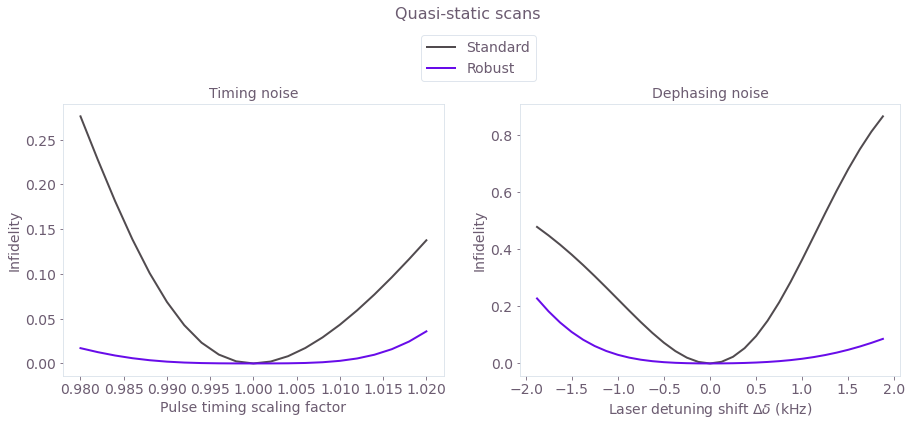

In [22]:
colors = ["#514B4F", "#680CE9"]

gs = gridspec.GridSpec(1, 2)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(3 * 5)
fig.suptitle("Quasi-static scans", fontsize=16, y=1.15)

ax = fig.add_subplot(gs[0])
ax.set_title("Timing noise", fontsize=14)
maxshift = 0.02
timeshifts = np.linspace(1 - maxshift, 1 + maxshift, timing_scan_points)
ax.plot(timeshifts, infids_timing, label="Standard", color=colors[0], linewidth=2)
ax.plot(timeshifts, robust_infids_timing, label="Robust", color=colors[1], linewidth=2)
ax.tick_params(labelsize=14)
ax.set_xlabel("Pulse timing scaling factor", fontsize=14)
ax.set_ylabel("Infidelity", fontsize=14)

ax = fig.add_subplot(gs[1])
ax.set_title("Dephasing noise", fontsize=14)
maxshift = 4000 * minreldet / 10000
detshifts = np.linspace(-maxshift, maxshift, dephasing_scan_points)
ax.plot(
    detshifts / 1000, infids_dephasing, label="Standard", color=colors[0], linewidth=2
)
ax.plot(
    detshifts / 1000,
    robust_infids_dephasing,
    label="Robust",
    color=colors[1],
    linewidth=2,
)
ax.tick_params(labelsize=14)
ax.set_xlabel("Laser detuning shift $\Delta \delta$ (kHz)", fontsize=14)
ax.set_ylabel("Infidelity", fontsize=14)
ax.legend(loc="best", bbox_to_anchor=(0.06, 1.28), fontsize=14)
plt.show()

The broader high-fidelity region indicates the benefit of the robust optimized pulses when there is quasi-static dephasing noise or noise in the control pulse timings.

## Experimental validation of two-ion gates

The optimized 'Standard' control method and the 'Robust' method (using the same robustness conditions) have been performed in experiment ([Milne et al., Phys. Rev. Applied, 2020](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.13.024022)).
This work examined phase-modulation for two-qubit gates, where the shared drive has fixed Rabi frequency and variable phase. The target gate operation $U_c$ acts on the initial state $|00\rangle$ to produce a maximally-entangled Bell state:
$$U_c |00\rangle = \frac{1}{\sqrt{2}} (|00\rangle -i |11\rangle).$$
The Standard and Robust drives were optimized to perform the operation $U_c$, and were assessed for robustness to laser detuning error both theoretically and in experiment:

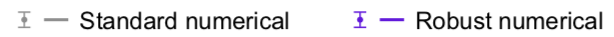

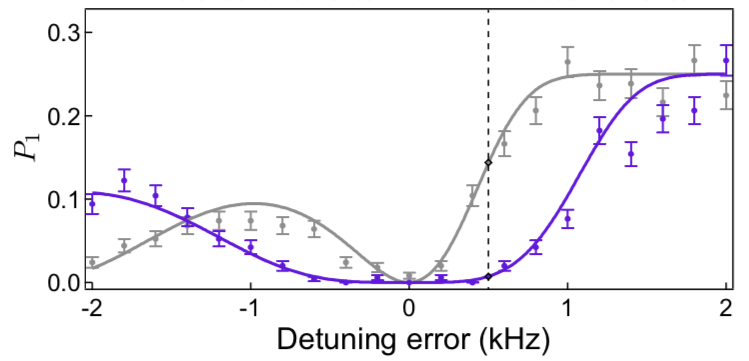

Solid lines are from theoretical simulation, and the data points are from the experiment. Experimental data is shown with error bars derived from quantum projection noise on the state population estimates and a fit of the parity contrast. Phase space trajectories are presented in the paper ([Milne et al., Phys. Rev. Applied, 2020](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.13.024022)) for the detuning error marked by the dashed black line.

The figure displays $P_1$, which is the probability of (only) a single ion (either of the two trapped ions) being projected into the state $|1\rangle$. $P_1 > 0$ is thus an indication of error in the gate. Both gates successfully perform the operation with no detuning error. The robust numerical solution has a much broader $P_1 \simeq 0$ region, validated in experiment.

The broad robustness region for the two-ion robust solution is in agreement with the theoretical robustness assessment for the two-qubit gates obtained in the above section. Note that the experimental implementation uses phase modulation, while the above solutions have phase and amplitude modulation.  Additionally, the $P_1$ measure is not the same as the operational infidelity plotted in section 1.

## Creating Q-CTRL pulses for parallel 2-of-5 and 3-of-5 qubit gates

Using preview features in BOULDER OPAL, you can obtain control solutions for configurable multi-qubit gates. These gates can also be performed simultaneously (in parallel). In this example, you'll learn to perform simultaneous two-qubit and three-qubit entangling operations.

First specify the ion, trap and laser characteristics.

In [25]:
# Trap characteristics
number_of_ions = 5

# Laser characteristics
maximum_rabi_rate = 2 * np.pi * 100e3
laser_detuning = 1.6e6 + 4.7e3

# Derived setup parameters
ion_chain_properties = qctrl.functions.calculate_ion_chain_properties(
    atomic_mass=171,  # Yb ions
    ion_count=number_of_ions,
    # Center of mass frequencies
    radial_x_center_of_mass_frequency=1.6e6,
    radial_y_center_of_mass_frequency=1.5e6,
    axial_center_of_mass_frequency=0.3e6,
    # Laser wavevector
    radial_x_wave_number=(2 * np.pi) / 355e-9,
    radial_y_wave_number=(2 * np.pi) / 355e-9,
    axial_wave_number=0,
)

100%|██████████| 100/100 [00:02<00:00, 34.74it/s]


You can then collect the Lamb–Dicke parameters and relative detunings from the result, which will be used in the phase and displacement calculations for ions. For more information, see the [Optimizing Mølmer–Sørensen gates](https://docs.q-ctrl.com/boulder-opal/user-guides/optimizing-molmer-sorensen-gates) user guide.

In [26]:
# Collect Lamb Dicke parameters in the shape
# [<axis>, <collective_mode>, <ion>]
lamb_dicke_parameters = np.asarray(
    [
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.radial_x_mode_properties
        ],
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.radial_y_mode_properties
        ],
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.axial_mode_properties
        ],
    ]
)

# Collect relative detunings in the shape
# [<axis>, <collective_mode>]
relative_detunings = (
    np.asarray(
        [
            [mode.frequency for mode in ion_chain_properties.radial_x_mode_properties],
            [mode.frequency for mode in ion_chain_properties.radial_y_mode_properties],
            [mode.frequency for mode in ion_chain_properties.axial_mode_properties],
        ]
    )
    - laser_detuning
)

To demonstrate simultaneous two- and three-qubit gates, configure the target operation by specifiying target relative phases between each ion pair. Recall that element ($j$, $k$) of the target phase array is the relative phase between ions $j$ and $k$, with $k<j$. In the cell below, the target relative phase for the ion pair (1, 0) is set to $\pi/4$ for maximal two-qubit entanglement. For the three-qubit gate, the same relative phase is specified for ion pairs (3, 2), (4, 2) and (4, 3).

In [27]:
# Operation duration in seconds
duration = 3e-4

# Target phases: element (j,k) is the relative entanglement for ions j and k (k<j)
target = np.array(
    [
        [0, 0, 0, 0, 0],
        [np.pi / 4, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, np.pi / 4, 0, 0],
        [0, 0, np.pi / 4, np.pi / 4, 0],
    ]
)

### Generating optimized pulses

To control the system, consider separately-tunable complex drives $\gamma_j (t) = \Omega_j e^{i \phi_j}$ that address each ion $j$ in the trap. The drives are piecewise-constant with amplitude and phase modulation. As above, the optimized cost and infidelity quantify the solution performance.

In [28]:
number_of_segments = 128
sample_times = np.linspace(0, duration, number_of_segments)

drive_names = ["ion_drive" + str(number) for number in range(number_of_ions)]

In [29]:
result_optimal = optimization_with_different_drives(
    ion_count=number_of_ions,
    number_of_segments=number_of_segments,
    duration=duration,
    maximum_rabi_rate=maximum_rabi_rate,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    sample_times=sample_times,
    robust=False,
    drive_names=drive_names,
)

100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


In [30]:
print("Cost = Infidelity = ", result_optimal.output["infidelity"]["value"])

Cost = Infidelity =  6.657408402332976e-09


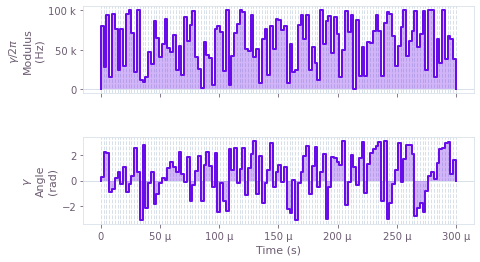

In [31]:
control = {f"$\gamma$": result_optimal.output[drive_names[0]]}
plot_controls(plt.figure(), control)

The figure displays the optimized pulse modulus and phase dynamics for ion 0.

### Generating robust optimized pulses

To obtain robust controls, impose symmetry on each drive and optimize such that the centre of mass of each mode's trajectory is at zero. This is the same procedure as for the two-qubit case.

In [32]:
# Robust optimization
number_of_optimizations = 10
result_robust = optimization_with_different_drives(
    ion_count=number_of_ions,
    number_of_segments=number_of_segments,
    duration=duration,
    maximum_rabi_rate=maximum_rabi_rate,
    lamb_dicke_parameters=lamb_dicke_parameters,
    relative_detunings=relative_detunings,
    sample_times=sample_times,
    robust=True,
    drive_names=drive_names,
)

100%|██████████| 100/100 [05:07<00:00,  3.07s/it]


In [33]:
print("Cost = ", result_robust.cost)
print("Infidelity = ", result_robust.output["infidelity"]["value"])

Cost =  3.1436189200854836e-07
Infidelity =  1.0134154326824074e-07


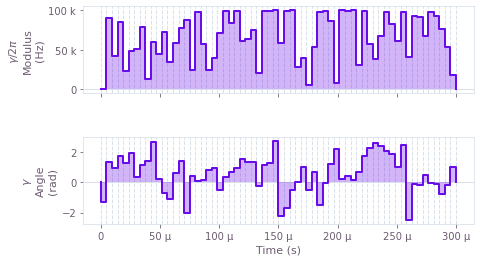

In [34]:
control = {f"$\gamma$": result_robust.output[drive_names[0]]}
plot_controls(plt.figure(), control)

The above figure displays the dynamics of the modulus and angle of the robust optimized pulse for ion 0. The symmetry in time of the modulus values can be observed.

### Operation verification with phase space trajectories

Next, visualize the trajectory of the center of a coherent state in (rotating) optical phase space for each mode. The closure of these trajectories is a necessary condition for an effective operation. First examine the (non-robust) standard optimized control, followed by the robust optimized control.

In [35]:
# Sum over ion index to obtain total displacement of the mode.
trajl = np.sum(result_optimal.output["displacements"]["value"], axis=3)

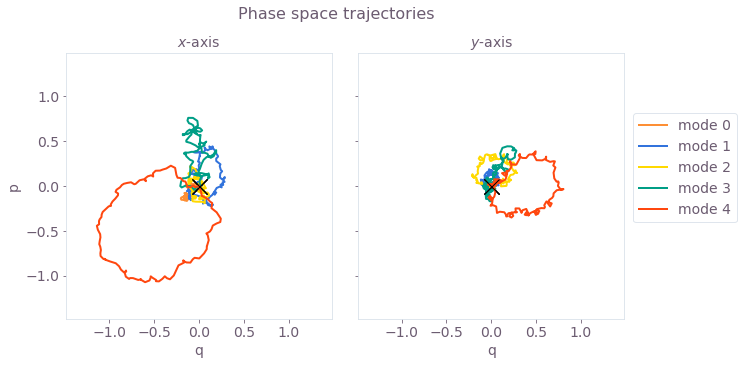

In [36]:
colors = ["#FD8F35", "#3273DC", "#FFD900", "#009E86", "#FF470F"]
scale = 1.1 * np.max(np.abs(trajl))

gs = gridspec.GridSpec(1, 2, wspace=0.1)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(2.0 * 5)
fig.suptitle("Phase space trajectories", fontsize=16, y=1.0)

ax = fig.add_subplot(gs[0])
ax.tick_params(labelsize=14)
for mode in range(number_of_ions):
    ax.plot(
        np.real(trajl[:, 0, mode]),
        np.imag(trajl[:, 0, mode]),
        label="mode " + str(mode % 5),
        color=colors[mode],
        linewidth=2,
    )
    ax.plot(
        np.real(trajl[-1, 0, mode]),
        np.imag(trajl[-1, 0, mode]),
        marker="x",
        color="black",
        markersize=15,
    )
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_aspect("equal")
ax.set_xlabel("q", fontsize=14)
ax.set_ylabel("p", fontsize=14)
ax.set_title("$x$-axis", fontsize=14)

ax = fig.add_subplot(gs[1])
ax.tick_params(labelsize=14)
for mode in range(number_of_ions):
    ax.plot(
        np.real(trajl[:, 1, mode]),
        np.imag(trajl[:, 1, mode]),
        label="mode " + str(mode % 5),
        color=colors[mode % 5],
        linewidth=2,
    )
    ax.plot(
        np.real(trajl[-1, 1, mode]),
        np.imag(trajl[-1, 1, mode]),
        marker="x",
        color="black",
        markersize=15,
    )
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_aspect("equal")
ax.set_xlabel("q", fontsize=14)
ax.yaxis.set_ticklabels([])
ax.set_title("$y$-axis", fontsize=14)
ax.legend(loc="best", bbox_to_anchor=(1.45, 0.8), fontsize=14)

plt.show()

The black cross marks the final displacement for each mode. These are overlapping at zero, indicating no residual state-motional entanglement and no motional heating caused by the operations.

Now visualize the phase space trajectories for the robust optimized control.

In [37]:
# Sum over ion index to obtain total displacement of the mode.
trajl_r = np.sum(result_robust.output["displacements"]["value"], axis=3)

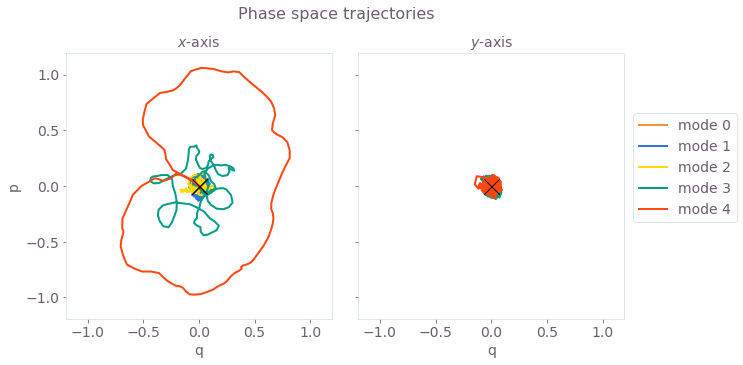

In [38]:
colors = ["#FD8F35", "#3273DC", "#FFD900", "#009E86", "#FF470F"]
scale = 1.1 * np.max(np.abs(trajl_r))

gs = gridspec.GridSpec(1, 2, wspace=0.1)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(2.0 * 5)
fig.suptitle("Phase space trajectories", fontsize=16, y=1.0)

ax = fig.add_subplot(gs[0])
ax.tick_params(labelsize=14)
for mode in range(number_of_ions):
    ax.plot(
        np.real(trajl_r[:, 0, mode]),
        np.imag(trajl_r[:, 0, mode]),
        label="mode " + str(mode % 5),
        color=colors[mode],
        linewidth=2,
    )
    ax.plot(
        np.real(trajl_r[-1, 0, mode]),
        np.imag(trajl_r[-1, 0, mode]),
        marker="x",
        color="black",
        markersize=15,
    )
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_aspect("equal")
ax.set_xlabel("q", fontsize=14)
ax.set_ylabel("p", fontsize=14)
ax.set_title("$x$-axis", fontsize=14)

ax = fig.add_subplot(gs[1])
ax.tick_params(labelsize=14)
for mode in range(number_of_ions):
    ax.plot(
        np.real(trajl_r[:, 1, mode]),
        np.imag(trajl_r[:, 1, mode]),
        label="mode " + str(mode % 5),
        color=colors[mode % 5],
        linewidth=2,
    )
    ax.plot(
        np.real(trajl_r[-1, 1, mode]),
        np.imag(trajl_r[-1, 1, mode]),
        marker="x",
        color="black",
        markersize=15,
    )
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_aspect("equal")
ax.set_xlabel("q", fontsize=14)
ax.yaxis.set_ticklabels([])
ax.set_title("$y$-axis", fontsize=14)
ax.legend(loc="best", bbox_to_anchor=(1.45, 0.8), fontsize=14)

plt.show()

Again, the black crosses at the origin indicate no residual state-motional entanglement, which arises from satisfying the center of mass and symmetry conditions.

### Operation verification with relative phase dynamics

You can also obtain the phase accumulation for each pair of ions. The target phases for each pair of ions should be achieved at the end of a successful operation. First consider the standard optimized control.

In [39]:
phases = result_optimal.output["phases"]["value"]

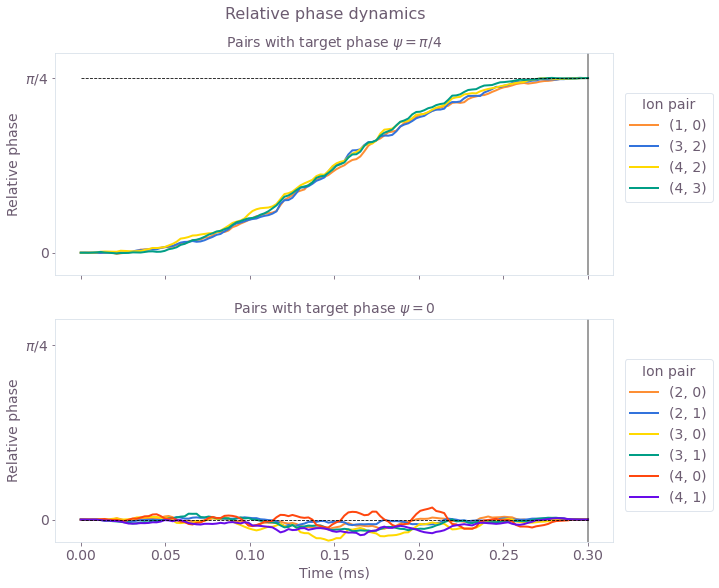

In [40]:
colors = ["#FD8F35", "#3273DC", "#FFD900", "#009E86", "#FF470F", "#680CE9"]

gs = gridspec.GridSpec(2, 1)
fig = plt.figure()
fig.set_figheight(1.8 * 5)
fig.set_figwidth(10)
fig.suptitle("Relative phase dynamics", fontsize=16, y=0.95)

ax0 = fig.add_subplot(gs[0])
ax0.tick_params(labelsize=14)
ax1 = fig.add_subplot(gs[1])
ax1.tick_params(labelsize=14)
x_timing = sample_times * 1e3

ind_col0 = 0
ind_col1 = 0
for ion1 in range(number_of_ions):
    for ion2 in range(ion1):
        if target[ion1][ion2] == np.pi / 4:
            ax0.plot(
                x_timing,
                phases[:, ion1, ion2],
                color=colors[ind_col0],
                label="(" + str(ion1) + ", " + str(ion2) + ")",
                linewidth=2,
            )
            ind_col0 += 1
        else:
            ax1.plot(
                x_timing,
                phases[:, ion1, ion2],
                color=colors[ind_col1],
                label="(" + str(ion1) + ", " + str(ion2) + ")",
                linewidth=2,
            )
            ind_col1 += 1

unit = np.pi / 4
ymax = np.pi / 4
ymin = 0 * np.pi / 4
y_tick = np.arange(ymin, ymax + unit, unit)
y_label = [r"0", r"$\pi/4$"]
ax0.set_yticks(y_tick)
ax0.set_yticklabels(y_label)
ax1.set_yticks(y_tick)
ax1.set_yticklabels(y_label)
ax0.plot([0, x_timing[-1]], [np.pi / 4, np.pi / 4], "k--", linewidth=0.8)
ax1.plot([0, x_timing[-1]], [0, 0], "k--", linewidth=0.8)
ax0.plot([x_timing[-1], x_timing[-1]], [-4, 4], "k", alpha=0.5)
ax1.plot([x_timing[-1], x_timing[-1]], [-4, 4], "k", alpha=0.5)
ax0.set_ylim((-0.1, 0.9))
ax1.set_ylim((-0.1, 0.9))
ax0.xaxis.set_ticklabels([])
ax1.set_xlabel("Time (ms)", fontsize=14)
ax0.set_ylabel("Relative phase", fontsize=14)
ax1.set_ylabel("Relative phase", fontsize=14)
ax0.set_title("Pairs with target phase $\psi = \pi/4$", fontsize=14)
ax1.set_title("Pairs with target phase $\psi = 0$", fontsize=14)
ax0.legend(
    bbox_to_anchor=(1.02, 0.82),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=14,
    title="Ion pair",
    title_fontsize=14,
)
ax1.legend(
    bbox_to_anchor=(1.02, 0.82),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=14,
    title="Ion pair",
    title_fontsize=14,
)
plt.show()

These figures display the relative phase dynamics for the duration of the gate operation, and the end of the operation is marked by vertical black lines. For clarity, different plots display the ion pairs with different target relative phases. The two plots are for target relative phases of $\pi/4$ and 0, and these values are marked with black horizontal dashed lines.

Next consider the phase accumulation for the robust optimized control.

In [41]:
phases_r = result_robust.output["phases"]["value"]

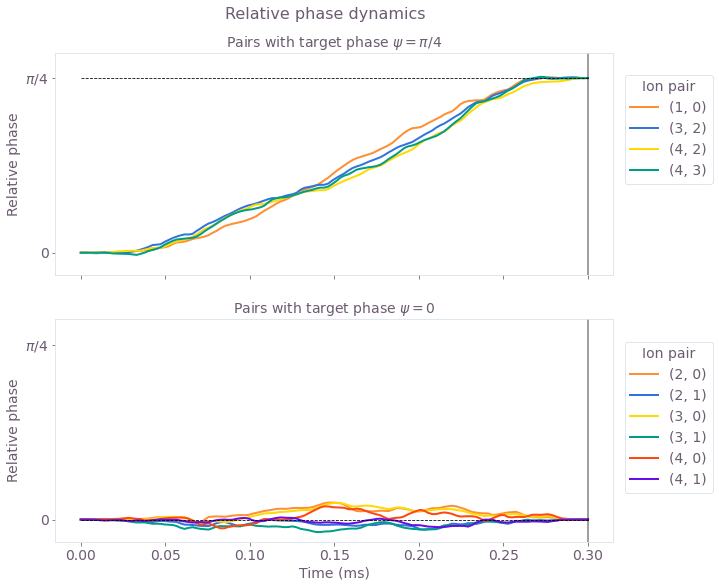

In [42]:
gs = gridspec.GridSpec(2, 1)
fig = plt.figure()
fig.set_figheight(1.8 * 5)
fig.set_figwidth(10)
fig.suptitle("Relative phase dynamics", fontsize=16, y=0.95)

ax0 = fig.add_subplot(gs[0])
ax0.tick_params(labelsize=14)
ax1 = fig.add_subplot(gs[1])
ax1.tick_params(labelsize=14)
x_timing = sample_times * 1e3

ind_col0 = 0
ind_col1 = 0
for ion1 in range(number_of_ions):
    for ion2 in range(ion1):
        if target[ion1][ion2] == np.pi / 4:
            ax0.plot(
                x_timing,
                phases_r[:, ion1, ion2],
                color=colors[ind_col0],
                label="(" + str(ion1) + ", " + str(ion2) + ")",
                linewidth=2,
            )
            ind_col0 += 1
        else:
            ax1.plot(
                x_timing,
                phases_r[:, ion1, ion2],
                color=colors[ind_col1],
                label="(" + str(ion1) + ", " + str(ion2) + ")",
                linewidth=2,
            )
            ind_col1 += 1

unit = np.pi / 4
ymax = np.pi / 4
ymin = 0 * np.pi / 4
y_tick = np.arange(ymin, ymax + unit, unit)
y_label = [r"0", r"$\pi/4$"]
ax0.set_yticks(y_tick)
ax0.set_yticklabels(y_label)
ax1.set_yticks(y_tick)
ax1.set_yticklabels(y_label)
ax0.plot([0, x_timing[-1]], [np.pi / 4, np.pi / 4], "k--", linewidth=0.8)
ax1.plot([0, x_timing[-1]], [0, 0], "k--", linewidth=0.8)
ax0.plot([x_timing[-1], x_timing[-1]], [-4, 4], "k", alpha=0.5)
ax1.plot([x_timing[-1], x_timing[-1]], [-4, 4], "k", alpha=0.5)
ax0.set_ylim((-0.1, 0.9))
ax1.set_ylim((-0.1, 0.9))
ax0.xaxis.set_ticklabels([])
ax1.set_xlabel("Time (ms)", fontsize=14)
ax0.set_ylabel("Relative phase", fontsize=14)
ax1.set_ylabel("Relative phase", fontsize=14)
ax0.set_title("Pairs with target phase $\psi = \pi/4$", fontsize=14)
ax1.set_title("Pairs with target phase $\psi = 0$", fontsize=14)
ax0.legend(
    bbox_to_anchor=(1.02, 0.9),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=14,
    title="Ion pair",
    title_fontsize=14,
)
ax1.legend(
    bbox_to_anchor=(1.02, 0.9),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=14,
    title="Ion pair",
    title_fontsize=14,
)
plt.show()

As above, these figures display the relative phase dynamics for the duration of the gate operation, and the end of the operation is marked by vertical black lines. The two plots are for target relative phases of $\pi/4$ and 0, and these values are marked with black horizontal dashed lines.

The optimized drives produce nontrivial relative phase dynamics for each ion pair since the ions are individually addressed. The entangling phase is mediated by coupling the ion pairs to shared motional modes, and the optimized drives (both standard and robust) provide the necessary degrees of freedom to achieve the different target relative phases for each ion pair.

### Verifying robustness to dephasing and pulse timing errors with quasi-static scans

You can assess the robustness of the 'Robust' optimized pulses in comparison to the 'Standard' optimized pulses using 1D quasi-static scans.

First, calculate a scan of scaling factors for the pulse timings. The scaling factors are applied uniformly: they scale the timing for the entire operation by the same factor.

In [43]:
maxshift = 0.004

timing_scan_points = 21

shifts = np.linspace(-maxshift, maxshift, timing_scan_points)
optimal_infidelity_names = [
    "infidelity" + str(number) for number in range(timing_scan_points)
]

with qctrl.create_graph() as graph:
    for (
        shift,
        infidelity_name,
    ) in zip(shifts, optimal_infidelity_names):
        drives = [
            qctrl.operations.pwc_signal(
                values=np.array(
                    [segment["value"] for segment in result_optimal.output[drive_name]]
                ),
                duration=duration * (1 + shift),
            )
            for drive_name in drive_names
        ]

        ms_phases = qctrl.operations.ms_phases(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )

        ms_displacements = qctrl.operations.ms_displacements(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )

        ms_infidelity = qctrl.operations.ms_infidelity(
            phases=ms_phases,
            displacements=ms_displacements,
            target_phases=target,
            name=infidelity_name,
        )

timing_scan = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=optimal_infidelity_names,
)

infids_timing = [timing_scan.output[name]["value"] for name in optimal_infidelity_names]

100%|██████████| 100/100 [00:09<00:00, 11.05it/s]


In [44]:
robust_infidelity_names = [
    "robust_infidelity" + str(number) for number in range(timing_scan_points)
]

with qctrl.create_graph() as graph:
    for shift, robust_infidelity_name in zip(shifts, robust_infidelity_names):
        drives = [
            qctrl.operations.pwc_signal(
                values=np.array(
                    [segment["value"] for segment in result_robust.output[drive_name]]
                ),
                duration=duration * (1 + shift),
            )
            for drive_name in drive_names
        ]

        ms_phases = qctrl.operations.ms_phases(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )

        ms_displacements = qctrl.operations.ms_displacements(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings,
        )

        ms_infidelity = qctrl.operations.ms_infidelity(
            phases=ms_phases,
            displacements=ms_displacements,
            target_phases=target,
            name=robust_infidelity_name,
        )

timing_scan = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=robust_infidelity_names,
)

robust_infids_timing = [
    timing_scan.output[name]["value"] for name in robust_infidelity_names
]

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Next, calculate the robustness of the optimized pulses using a systematic scan of the relative detunings (which corresponds to shifting the laser detuning).

In [45]:
minreldet = np.min(np.abs(relative_detunings))
maxshift = 4 * minreldet / 10000 * 100

dephasing_scan_points = 31

shifts = np.linspace(-maxshift, maxshift, dephasing_scan_points)
optimal_infidelity_names = [
    "infidelity" + str(number) for number in range(dephasing_scan_points)
]

with qctrl.create_graph() as graph:
    for shift, infidelity_name in zip(shifts, optimal_infidelity_names):
        drives = [
            qctrl.operations.pwc_signal(
                values=np.array(
                    [segment["value"] for segment in result_optimal.output[drive_name]]
                ),
                duration=duration,
            )
            for drive_name in drive_names
        ]

        ms_phases = qctrl.operations.ms_phases(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings + shift,
        )

        ms_displacements = qctrl.operations.ms_displacements(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings + shift,
        )

        ms_infidelity = qctrl.operations.ms_infidelity(
            phases=ms_phases,
            displacements=ms_displacements,
            target_phases=target,
            name=infidelity_name,
        )

dephasing_scan = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=optimal_infidelity_names,
)

infids_dephasing = [
    dephasing_scan.output[name]["value"] for name in optimal_infidelity_names
]

100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


In [46]:
robust_infidelity_names = [
    "robust_infidelity" + str(number) for number in range(dephasing_scan_points)
]

with qctrl.create_graph() as graph:
    for shift, robust_infidelity_name in zip(shifts, robust_infidelity_names):
        drives = [
            qctrl.operations.pwc_signal(
                values=np.array(
                    [segment["value"] for segment in result_robust.output[drive_name]]
                ),
                duration=duration,
            )
            for drive_name in drive_names
        ]

        ms_phases = qctrl.operations.ms_phases(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings + shift,
        )
        ms_displacements = qctrl.operations.ms_displacements(
            drives=drives,
            lamb_dicke_parameters=lamb_dicke_parameters,
            relative_detunings=relative_detunings + shift,
        )
        ms_infidelity = qctrl.operations.ms_infidelity(
            phases=ms_phases,
            displacements=ms_displacements,
            target_phases=target,
            name=robust_infidelity_name,
        )

dephasing_scan = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=robust_infidelity_names,
)

robust_infids_dephasing = [
    dephasing_scan.output[name]["value"] for name in robust_infidelity_names
]

100%|██████████| 100/100 [00:09<00:00, 10.93it/s]


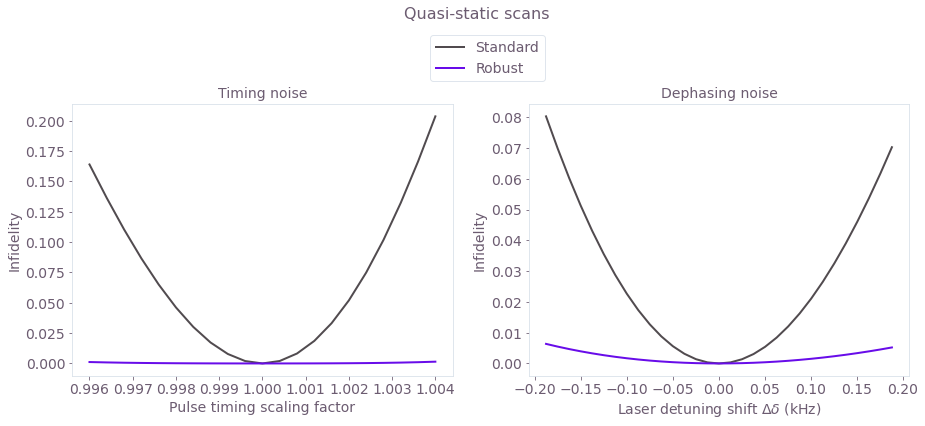

In [47]:
colors = ["#514B4F", "#680CE9"]

gs = gridspec.GridSpec(1, 2)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(3 * 5)
fig.suptitle("Quasi-static scans", fontsize=16, y=1.15)

ax = fig.add_subplot(gs[0])
ax.set_title("Timing noise", fontsize=14)
maxshift = 0.004
timeshifts = np.linspace(1 - maxshift, 1 + maxshift, timing_scan_points)
ax.plot(timeshifts, infids_timing, label="Standard", color=colors[0], linewidth=2)
ax.plot(timeshifts, robust_infids_timing, label="Robust", color=colors[1], linewidth=2)
ax.tick_params(labelsize=14)
ax.set_xlabel("Pulse timing scaling factor", fontsize=14)
ax.set_ylabel("Infidelity", fontsize=14)

ax = fig.add_subplot(gs[1])
ax.set_title("Dephasing noise", fontsize=14)
maxshift = 4 * minreldet / 10000 * 100
detshifts = np.linspace(-maxshift, maxshift, dephasing_scan_points)
ax.plot(
    detshifts / 1000, infids_dephasing, label="Standard", color=colors[0], linewidth=2
)
ax.plot(
    detshifts / 1000,
    robust_infids_dephasing,
    label="Robust",
    color=colors[1],
    linewidth=2,
)
ax.tick_params(labelsize=14)
ax.set_xlabel("Laser detuning shift $\Delta \delta$ (kHz)", fontsize=14)
ax.set_ylabel("Infidelity", fontsize=14)
ax.legend(loc="best", bbox_to_anchor=(0.06, 1.28), fontsize=14)
plt.show()

The broader high-fidelity regions indicate the benefit of the robust optimized pulses when there is quasi-static dephasing noise or noise in the control pulse timings.

The additional robustness for this more general gate is in agreement with the [experimental results](#Experimental-validation-of-two-ion-gates) presented earlier for two-ion gates, using related robustness methodology. These configurable gates are yet to be implemented in experiment: please contact us if you want a live demonstration of these features for your hardware.

## Creating Q-CTRL pulses for six parallel 2-of-12 qubit gates

Preview features in BOULDER OPAL include configurable multi-qubit gates. In this example, you can learn to obtain parallel pairwise entangling gates with specified control constraints: the high-frequency components of the drive are removed using a sinc filter within the optimizer, and each pair is given a different relative phase target. The target relative phase for each pair is specified to increase in steps of 0.2, as shown in the target phase array in the following cell.

In [48]:
# Trap characteristics
number_of_ions = 12

# Laser characteristics
maximum_rabi_rate = 2 * np.pi * 100e3
laser_detuning = 1.6e6 + 4.7e3

# Derived setup parameters
ion_chain_properties = qctrl.functions.calculate_ion_chain_properties(
    atomic_mass=171,  # Yb ions
    ion_count=number_of_ions,
    # Center of mass frequencies
    radial_x_center_of_mass_frequency=1.6e6,
    radial_y_center_of_mass_frequency=1.5e6,
    axial_center_of_mass_frequency=0.25e6,
    # Laser wavevector
    radial_x_wave_number=(2 * np.pi) / 355e-9,
    radial_y_wave_number=(2 * np.pi) / 355e-9,
    axial_wave_number=0,
)

100%|██████████| 100/100 [00:03<00:00, 33.07it/s]


You can then collect the Lamb–Dicke parameters and relative detunings from the result, which will be used in the phase and displacement calculations for ions. For more information, see the [Optimizing Mølmer–Sørensen gates](https://docs.q-ctrl.com/boulder-opal/user-guides/optimizing-molmer-sorensen-gates) user guide.

In [49]:
# Collect Lamb Dicke parameters in the shape
# [<axis>, <collective_mode>, <ion>]
lamb_dicke_parameters = np.asarray(
    [
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.radial_x_mode_properties
        ],
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.radial_y_mode_properties
        ],
        [
            mode.lamb_dicke_parameters
            for mode in ion_chain_properties.axial_mode_properties
        ],
    ]
)

# Collect relative detunings in the shape
# [<axis>, <collective_mode>]
relative_detunings = (
    np.asarray(
        [
            [mode.frequency for mode in ion_chain_properties.radial_x_mode_properties],
            [mode.frequency for mode in ion_chain_properties.radial_y_mode_properties],
            [mode.frequency for mode in ion_chain_properties.axial_mode_properties],
        ]
    )
    - laser_detuning
)

In [50]:
# Operation duration in seconds
duration = 3e-4

# Target phases: element (j,k) is the relative entanglement for ions j and k (k<j)
target = np.zeros((12, 12))
for ion1 in range(1, 12, 2):
    ion2 = ion1 - 1
    target[ion1][ion2] = ion1 / 10

### Generating optimized pulses

Consider separately-tunable complex drives $\gamma_j (t) = \Omega_j e^{i \phi_j}$ that address each ion $j$ in the trap. The drives are piecewise-constant with amplitude and phase modulation. Additionally, a low-pass (sinc) filter is incorporated into the optimizer to smooth the pulse, as required for many practical implementations.

You can set the number of optimized pulse segments and resampling segments for the smoothed pulse, as well as the sinc cutoff frequency (in Hz) in the cell below.

In [51]:
number_of_segments = 32
number_of_sample_segments = 128
sample_times = np.linspace(0, duration, number_of_sample_segments)
sinc_cutoff_frequency_drives = 2 * np.pi * 0.05e6

In [52]:
drive_names = ["ion_drive" + str(number) for number in range(number_of_ions)]

with qctrl.create_graph() as graph:
    sinc_filter_drives = qctrl.operations.sinc_integral_function(
        sinc_cutoff_frequency_drives
    )

    drives = []

    for drive_name in drive_names:
        drive_real_raw_values = qctrl.operations.bounded_optimization_variable(
            count=number_of_segments,
            lower_bound=-maximum_rabi_rate,
            upper_bound=maximum_rabi_rate,
        )
        drive_imag_raw_values = qctrl.operations.bounded_optimization_variable(
            count=number_of_segments,
            lower_bound=-maximum_rabi_rate,
            upper_bound=maximum_rabi_rate,
        )

        drive_raw = qctrl.operations.pwc_signal(
            values=drive_real_raw_values + 1j * drive_imag_raw_values,
            duration=duration,
        )

        drive_filtered = qctrl.operations.convolve_pwc(
            pwc=drive_raw,
            kernel_integral=sinc_filter_drives,
        )

        drives.append(
            qctrl.operations.discretize_stf(
                stf=drive_filtered,
                duration=duration,
                segments_count=number_of_sample_segments,
                name=drive_name,
            )
        )

    ms_phases = qctrl.operations.ms_phases(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
    )

    ms_displacements = qctrl.operations.ms_displacements(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
    )

    infidelity = qctrl.operations.ms_infidelity(
        phases=ms_phases,
        displacements=ms_displacements,
        target_phases=target,
        name="infidelity",
    )

In [53]:
number_of_optimizations = 3
result = qctrl.functions.calculate_optimization(
    graph=graph,
    optimization_count=number_of_optimizations,
    cost_node_name="infidelity",
    output_node_names=["infidelity"] + drive_names,
)

100%|██████████| 100/100 [15:20<00:00,  9.20s/it]


In [54]:
print("Cost = Infidelity = ", result.output["infidelity"]["value"])

Cost = Infidelity =  3.151113432298125e-06


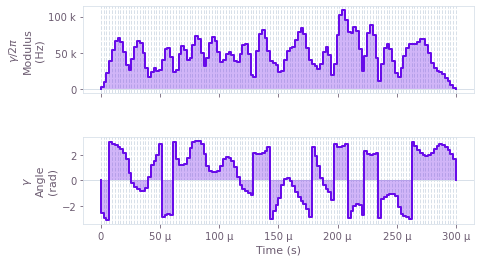

In [55]:
control = {f"$\gamma$": result.output["ion_drive0"]}
plot_controls(plt.figure(), control)

The above figure displays the optimized smooth pulse modulus and phase dynamics for ion 0.

### Operation verification with phase space trajectories

Next, visualize the trajectory of the center of a coherent state in (rotating) optical phase space for each mode. The closure of these trajectories is a necessary condition for an effective operation.

For a system as large as this, you can separate the simulation of the displacement from the optimization, to increase the efficiency.

In [56]:
with qctrl.create_graph() as graph:
    drives = [
        qctrl.operations.pwc_signal(
            values=np.array(
                [segment["value"] for segment in result.output[drive_name]]
            ),
            duration=duration,
        )
        for drive_name in drive_names
    ]

    ms_displacements = qctrl.operations.ms_displacements(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        sample_times=sample_times,
        name="displacements",
    )

displacement_simulation = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=["displacements"],
)

# Sum over ion index to obtain total displacement of the mode.
trajl = np.sum(displacement_simulation.output["displacements"]["value"], axis=3)

100%|██████████| 100/100 [00:05<00:00, 17.94it/s]


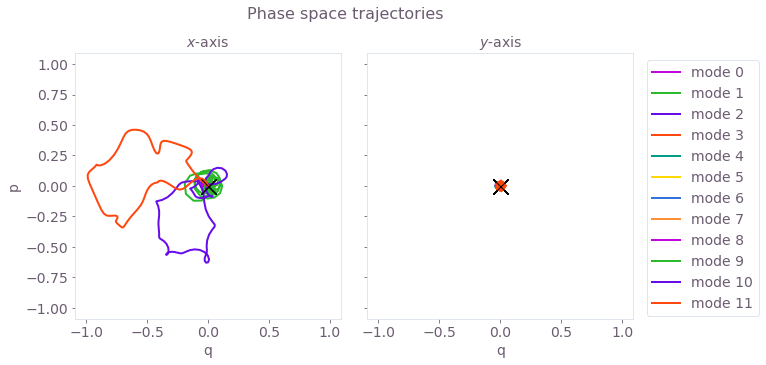

In [57]:
colors = np.flip(
    [
        "#FD8F35",
        "#3273DC",
        "#FFD900",
        "#009E86",
        "#FF470F",
        "#680CE9",
        "#2DB92D",
        "#BF04DC",
    ]
)
scale = 1.1 * np.max(np.abs(trajl))

gs = gridspec.GridSpec(1, 2, wspace=0.1)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(2.0 * 5)
fig.suptitle("Phase space trajectories", fontsize=16, y=1.0)

ax = fig.add_subplot(gs[0])
ax.tick_params(labelsize=14)
for mode in range(number_of_ions):
    ax.plot(
        np.real(trajl[:, 0, mode]),
        np.imag(trajl[:, 0, mode]),
        label="mode " + str(mode % 12),
        color=colors[mode % 8],
        linewidth=2,
    )
    ax.plot(
        np.real(trajl[-1, 0, mode]),
        np.imag(trajl[-1, 0, mode]),
        marker="x",
        color="black",
        markersize=15,
    )
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_aspect("equal")
ax.set_xlabel("q", fontsize=14)
ax.set_ylabel("p", fontsize=14)
ax.set_title("$x$-axis", fontsize=14)

ax = fig.add_subplot(gs[1])
ax.tick_params(labelsize=14)
for mode in range(number_of_ions):
    ax.plot(
        np.real(trajl[:, 1, mode]),
        np.imag(trajl[:, 1, mode]),
        label="mode " + str(mode % 12),
        color=colors[mode % 8],
        linewidth=2,
    )
    ax.plot(
        np.real(trajl[-1, 1, mode]),
        np.imag(trajl[-1, 1, mode]),
        marker="x",
        color="black",
        markersize=15,
    )
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_aspect("equal")
ax.set_xlabel("q", fontsize=14)
ax.yaxis.set_ticklabels([])
ax.set_title("$y$-axis", fontsize=14)
ax.legend(loc="best", bbox_to_anchor=(1.5, 1.0), fontsize=14)

plt.show()

The black cross marks the final displacement for each mode. These are overlapping at zero, indicating no residual state-motional entanglement and no motional heating caused by the operations.

### Operation verification with relative phase dynamics

You can also obtain the phase accumulation for each pair of ions. The target phases for each pair of ions should be achieved at the end of a successful operation.

For a system as large as this, you can separate the simulation of the phases from the optimization, to increase the efficiency.

In [58]:
with qctrl.create_graph() as graph:
    drives = [
        qctrl.operations.pwc_signal(
            values=np.array(
                [segment["value"] for segment in result.output[drive_name]]
            ),
            duration=duration,
        )
        for drive_name in drive_names
    ]

    ms_phases = qctrl.operations.ms_phases(
        drives=drives,
        lamb_dicke_parameters=lamb_dicke_parameters,
        relative_detunings=relative_detunings,
        sample_times=sample_times,
        name="phases",
    )

phase_simulation = qctrl.functions.calculate_graph(
    graph=graph,
    output_node_names=["phases"],
)

phases_6 = phase_simulation.output["phases"]["value"]

100%|██████████| 100/100 [00:12<00:00,  7.73it/s]


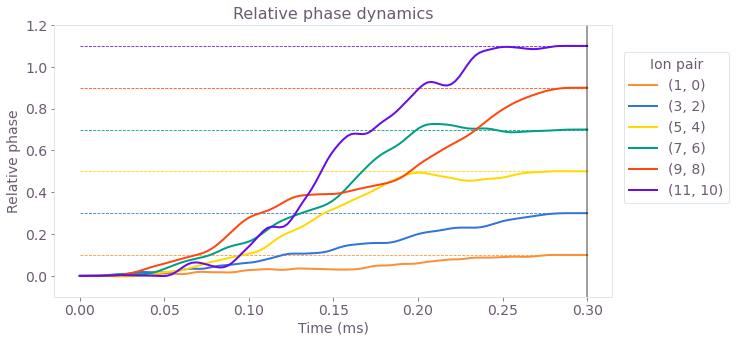

In [59]:
colors = ["#FD8F35", "#3273DC", "#FFD900", "#009E86", "#FF470F", "#680CE9"]

fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)
plt.title("Relative phase dynamics", fontsize=16, y=1)
ax.tick_params(labelsize=14)

x_timing = sample_times * 1e3
ind = 0
for ion1 in range(1, 12, 2):
    ion2 = ion1 - 1
    ax.plot(
        x_timing,
        np.array(phases_6[:, ion1, ion2]),
        color=colors[ind],
        label="(" + str(ion1) + ", " + str(ion2) + ")",
        linewidth=2,
    )
    ax.plot(
        [0, x_timing[-1]],
        [ion1 / 10, ion1 / 10],
        "--",
        color=colors[ind],
        linewidth=0.8,
    )
    ind += 1

ax.plot([x_timing[-1], x_timing[-1]], [-4, 4], "k", alpha=0.5)
ax.set_ylim((-0.1, 1.2))
ax.set_xlabel("Time (ms)", fontsize=14)
ax.set_ylabel("Relative phase", fontsize=14)
ax.legend(
    bbox_to_anchor=(1.02, 0.9),
    loc="upper left",
    borderaxespad=0.0,
    fontsize=14,
    title="Ion pair",
    title_fontsize=14,
)
plt.show()

The figure displays the relative phase dynamics for each entangled ion pair, with a color matched to the pair's target relative phase (dashed). Note that by the end of the operation, marked by the black vertical line, each ion pair achieves its specified, distinct relative phase target.